# Testing diffusion problem format

Grid and parameters

In [30]:
using Plots
using SparseArrays, LinearAlgebra

In [31]:
struct Grid
    xmax::Float64
    ymax::Float64

    nx::Int64
    ny::Int64
    
    Δx::Float64
    Δy::Float64

    xRange::Array{Float64,1}
    yRange::Array{Float64,1}

    function Grid(xmax, ymax, nx, ny)
        Δx = 2*xmax/(nx-1)
        Δy = 2*ymax/(ny-1)

        xRange = (-xmax:Δx:xmax)
        yRange = (-ymax:Δy:ymax)

        return new(xmax, ymax, nx, ny, Δx, Δy, xRange, yRange)
    end
end
struct Parameters
    ν::Float64
    σ::Float64
    tspan::Tuple{Float64,Float64}
end

Model setup

In [32]:
abstract type FluidModel end
mutable struct DiffusionModel{T<:Union{Function,Nothing}} <: FluidModel
    u0::Array{Float64,2}
    u_analytic::T
    
    grid::Grid
    parameters::Parameters
    
    Δt::Float64
    t::Array{Float64,1}
    
    function DiffusionModel(u0, u_analytic::T, grid, parameters) where T<:Union{Function,Nothing}
        Δt = parameters.σ*grid.Δx*grid.Δy/parameters.ν
        t = parameters.tspan[1]:Δt:parameters.tspan[2]
        return new{T}(u0, u_analytic, grid, parameters, Δt ,t)
    end
end
DiffusionModel(grid, parameters) = DiffusionModel(zeros(grid.ny, grid.nx), nothing, grid, parameters)
DiffusionModel(u0, grid, parameters) = DiffusionModel(u0, nothing, grid, parameters);

Test setup of model

In [33]:
function make_gaussian(grid::Grid)
    u0 = zeros(grid.ny, grid.nx)
    x = grid.xRange
    y = grid.yRange
    
    x₀ = 0.0
    y₀ = 0.0
    var₀ = 0.9
    T₀ = 1.0
    for j = 1 : grid.ny, i = 1 : grid.nx
        u0[j,i] = T₀*exp(-((x[i]-x₀)^2 + (y[j]-y₀)^2)/(2*var₀))
    end
    return u0
end
function solution_gaussian(grid::Grid, t, κ)
    uana = zeros(grid.ny, grid.nx)
    x = grid.xRange
    y = grid.yRange
    
    x₀ = 0.0
    y₀ = 0.0
    var₀ = 0.9
    T₀ = 1.0
    #t₀ = -0.1
    
    for j = 1 : grid.ny, i = 1 : grid.nx
        uana[j,i] = T₀/sqrt(1+4*κ*t/var₀)*
                exp(-((x[i]-x₀)^2 + (y[j]-y₀)^2)/(2*var₀+4*κ*t))
        #uana[j,i] = 1/sqrt(4*pi*κ*(t-t₀))*
        #        exp(-((x[i]-x₀)^2 + (y[j]-y₀)^2)/(4*pi*κ*(t-t₀)))
    end
    return uana
end;

In [34]:
grid_test = Grid(5., 5., 64, 64)
param_test = Parameters(1.44, 0.01, (0.0, 0.1))
u0_test = make_gaussian(grid_test)
#u0_test = solution_gaussian(grid_test, 0, -0.05, param_test.ν)
uana_test(t) = solution_gaussian(grid_test, t, param_test.ν)

mod_test = DiffusionModel(u0_test, uana_test, grid_test, param_test)
#mod_test = DiffusionModel(u0_test, grid_test, param_test)
dump(mod_test)

DiffusionModel{typeof(uana_test)}
  u0: Array{Float64}((64, 64)) [8.635040753377376e-13 2.056653577206363e-12 … 2.056653577206363e-12 8.635040753377376e-13; 2.056653577206363e-12 4.8984411972593484e-12 … 4.8984411972593484e-12 2.056653577206363e-12; … ; 2.056653577206363e-12 4.8984411972593484e-12 … 4.8984411972593484e-12 2.056653577206363e-12; 8.635040753377376e-13 2.056653577206363e-12 … 2.056653577206363e-12 8.635040753377376e-13]
  u_analytic: uana_test (function of type typeof(uana_test))
  grid: Grid
    xmax: Float64 5.0
    ymax: Float64 5.0
    nx: Int64 64
    ny: Int64 64
    Δx: Float64 0.15873015873015872
    Δy: Float64 0.15873015873015872
    xRange: Array{Float64}((64,)) [-5.0, -4.841269841269841, -4.682539682539683, -4.523809523809524, -4.365079365079365, -4.2063492063492065, -4.0476190476190474, -3.888888888888889, -3.7301587301587302, -3.5714285714285716  …  3.5714285714285716, 3.7301587301587302, 3.888888888888889, 4.0476190476190474, 4.2063492063492065, 4.365079365

0.9930257495086255


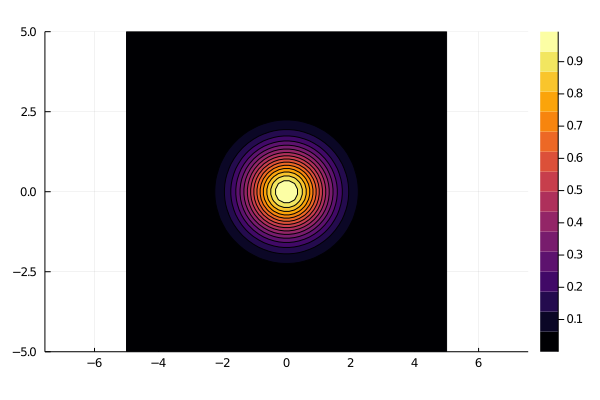

In [35]:
println(maximum(u0_test))
contourf(grid_test.xRange, grid_test.yRange, u0_test, aspect_ratio=:equal)

0.77673957318786


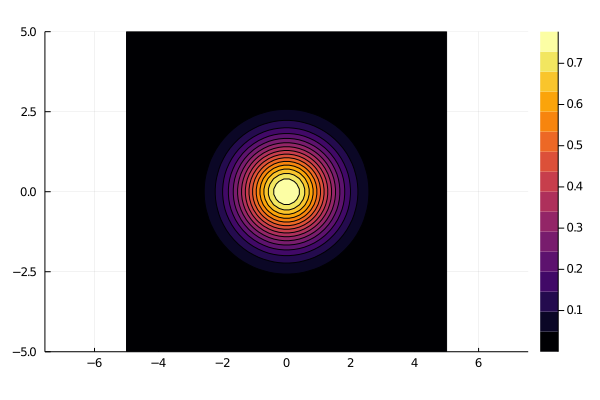

In [36]:
println(maximum(uana_test(0.1)))
contourf(grid_test.xRange, grid_test.yRange, uana_test(0.1), aspect_ratio=:equal)

# Solving methods

1. Cache

In [37]:
abstract type DiffusionCache end
mutable struct ExplicitDiffusionCache <: DiffusionCache
    u::Array{Float64,2}
    uprev::Array{Float64,2}
    t::Float64
end
# NOTE: Add types for a matrices
mutable struct CNDiffusionCache <: DiffusionCache
    u::Array{Float64,2}
    uprev::Array{Float64,2}
    rhs::Array{Float64,2}
    a1
    a2
    t::Float64
end
mutable struct ADIDiffusionCache <: DiffusionCache
    u::Array{Float64,2}
    uhalf::Array{Float64,2}
    uprev::Array{Float64,2}
    rhs::Array{Float64,2}
    a1x
    a1y
    a2x
    a2y
    t::Float64
end

Methods

In [38]:
abstract type DiffusionMethod end
struct ExplicitDiffusion <: DiffusionMethod end
struct CrankNickolsonDiffusion <: DiffusionMethod end
struct ADIDiffusion <: DiffusionMethod end

In [39]:
function perform_step!(model::DiffusionModel, method::ExplicitDiffusion, cache::ExplicitDiffusionCache)
    u  = cache.u
    un = cache.uprev
    nx = model.grid.nx
    ny = model.grid.ny
    Δx = model.grid.Δx
    Δy = model.grid.Δy
    Δt = model.Δt
    ν  = model.parameters.ν
    
    copy!(un,u)
    @inbounds for j in 2:ny-1, i in 2:nx-1
        u[j,i] = un[j,i] + 
            ν*Δt/(Δx*Δx)*(un[j  ,i+1]-2*un[j,i]+un[j  ,i-1]) + 
            ν*Δt/(Δy*Δy)*(un[j+1,i  ]-2*un[j,i]+un[j-1,i  ])
    end
    
    return nothing
end
function perform_step!(model::DiffusionModel, method::CrankNickolsonDiffusion, cache::CNDiffusionCache)
    u   = cache.u
    un  = cache.uprev
    rhs = cache.rhs
    a1  = cache.a1
    a2  = cache.a2
    
    copy!(un,u)
    
    unV = @view un[2:end-1,2:end-1]
    unVC = @view unV[:]
    uV = @view u[2:end-1,2:end-1]
    uVC = @view uV[:]
    rhsV = @view rhs[2:end-1,2:end-1]
    rhsVC = @view rhsV[:]

    mul!(rhsVC, a2, unVC)
    uVC .= a1\rhsV[:]

    return nothing
end
function perform_step!(model::DiffusionModel, method::ADIDiffusion, cache::ADIDiffusionCache)
    u      = cache.u
    uhalf  = cache.uhalf
    un     = cache.uprev
    rhs    = cache.rhs
    a1x    = cache.a1x
    a1y    = cache.a1y
    a2x    = cache.a2x
    a2y    = cache.a2y
    nx, ny = model.grid.nx, model.grid.ny
    
    copy!(un,u)
  
    un_i(i) = @view un[2:end-1,i]
    u_i(i) = @view u[2:end-1,i]
    rhs_j(j) = @view rhs[j,2:end-1]
    rhs_i(i) = @view rhs[2:end-1,i]
    uhalf_j(j) = @view uhalf[j,2:end-1]

    # Step one
    for i = 2:nx-1
        mul!(rhs_i(i), a2y, un_i(i))
    end
    for j = 2:ny-1
        ldiv!(uhalf_j(j), a1x, rhs_j(j))
    end

    # Step two
    for j = 2:ny-1
        mul!(rhs_j(j), a2x, uhalf_j(j))
    end
    for i = 2:nx-1
        ldiv!(u_i(i), a1y, rhs_i(i))
    end
    return nothing
end
function apply_BCs!(cache)
    u = cache.u
    u[1,:]   .= 0.0
    u[end,:] .= 0.0
    u[:,1]   .= 0.0
    u[:,end] .= 0.0
    return nothing
end;

In [40]:
# Cache initialisers
init_cache(model, method::ExplicitDiffusion) = 
    ExplicitDiffusionCache(copy(model.u0), copy(model.u0), copy(mod_test.parameters.tspan[1]))
function init_cache(model, method::CrankNickolsonDiffusion)
    u     = copy(model.u0)
    uprev = copy(model.u0)
    rhs   = copy(model.u0)
    
    a1, a2 = init_CN(model)
    
    t = copy(mod_test.parameters.tspan[1])
    
    return CNDiffusionCache(u, uprev, rhs, a1, a2, t);
end
function init_cache(model, method::ADIDiffusion)
    u     = copy(model.u0)
    uhalf = copy(model.u0)
    uprev = copy(model.u0)
    rhs   = copy(model.u0)
    
    a1x, a1y, a2x, a2y = init_ADI(model)
    
    t = copy(mod_test.parameters.tspan[1])
    
    return ADIDiffusionCache(u, uhalf, uprev, rhs, a1x, a1y, a2x, a2y, t);
end;

In [41]:
# Matrix solvers
function init_CN(model)
    nx, ny = model.grid.nx, model.grid.ny
    Δx, Δy = model.grid.Δx, model.grid.Δy
    ν, Δt  = model.parameters.ν, model.Δt
    
    Nx = (nx-2)
    Ny = (ny-2)
    Nxy = Nx*Ny
    βx = 0.5*ν*Δt/(Δx*Δx)
    βy = 0.5*ν*Δt/(Δy*Δy)

    # New a1
    a1 = spzeros(Nxy,Nxy)
    ij_ind = LinearIndices((1:Ny, 1:Nx))
    for ij in ij_ind
        a1[ij,ij] = 1 + 2*βx + 2*βy
    end
    for ij in 1:Nx*(Ny-1)
        a1[view(ij_ind,2:Ny,:)[ij],view(ij_ind,1:Ny-1,:)[ij]] = -βy # Up
        a1[view(ij_ind,1:Ny-1,:)[ij],view(ij_ind,2:Ny,:)[ij]] = -βy # Down
    end
    for ij in 1:(Nx-1)*Ny
        a1[view(ij_ind,:,2:Nx)[ij],view(ij_ind,:,1:Nx-1)[ij]] = -βx # Right
        a1[view(ij_ind,:,1:Nx-1)[ij],view(ij_ind,:,2:Nx)[ij]] = -βx # Left
    end

    # New a2
    a2 = spzeros(Nxy,Nxy)
    ij_ind = LinearIndices((1:Ny, 1:Nx))
    for ij in ij_ind
        a2[ij,ij] = 1 - 2*βx - 2*βy
    end
    for ij in 1:Nx*(Ny-1)
        a2[view(ij_ind,2:Ny,:)[ij],view(ij_ind,1:Ny-1,:)[ij]] = βy # Up
        a2[view(ij_ind,1:Ny-1,:)[ij],view(ij_ind,2:Ny,:)[ij]] = βy # Down
    end
    for ij in 1:(Nx-1)*Ny
        a2[view(ij_ind,:,2:Nx)[ij],view(ij_ind,:,1:Nx-1)[ij]] = βx # Right
        a2[view(ij_ind,:,1:Nx-1)[ij],view(ij_ind,:,2:Nx)[ij]] = βx # Left
    end

    a1_lu = factorize(a1)
    return a1_lu, a2
end
function init_ADI(model)
    nx, ny = model.grid.nx, model.grid.ny
    Δx, Δy = model.grid.Δx, model.grid.Δy
    ν, Δt  = model.parameters.ν, model.Δt
    
    βx = 0.5*ν*Δt/(Δx*Δx)
    βy = 0.5*ν*Δt/(Δy*Δy)
    d1x = ones(nx-2) .+ 2 * βx
    e1x = -βx * ones(nx-3)
    d1y = ones(ny-2) .+ 2 * βy
    e1y = -βy * ones(ny-3)
    # matrix ( I - 0.5 nu dt delta_x^2 )
    a1x = SymTridiagonal(d1x,e1x)
    a1y = SymTridiagonal(d1y,e1y)

    d2x = ones(nx-2) .- 2 * βx
    e2x = -βx * ones(nx-3)
    d2y = ones(ny-2) .- 2 * βy
    e2y = -βy * ones(ny-3)
    # matrix ( I + 0.5 nu dt delta_x^2) 
    a2x = SymTridiagonal(d2x,-e2x)
    a2y = SymTridiagonal(d2y,-e2y)

    #LDLt factorize
    a1x_ldlt = factorize(a1x)
    a1y_ldlt = factorize(a1y)
    return a1x_ldlt, a1y_ldlt, a2x, a2y
end;

Problem = model + method + (cache)

In [42]:
abstract type FluidProblem end
mutable struct DiffusionProblem{MethodType<:DiffusionMethod, CacheType<:DiffusionCache} <: FluidProblem
    model::DiffusionModel
    method::MethodType
    cache::CacheType
end
function DiffusionProblem(model, M::MethodType) where MethodType
    cache = init_cache(model, M)
    CacheType = typeof(cache)
    return DiffusionProblem{MethodType, CacheType}(model, M, cache)
end;

In [43]:
abstract type FluidSolution end
mutable struct DiffusionSolution{T<:Union{Array{Float64,2},Nothing}} <: FluidSolution
    u::Array{Float64,2}
    
    u_analytic::T
    errors::T
    
    prob::DiffusionProblem
    retcode::Bool
end
function DiffusionSolution(prob::DiffusionProblem, retcode::Bool)
    u_analytic, errors = get_analytic(prob.model, prob.cache.u, prob.cache.t)
    return DiffusionSolution(prob.cache.u, u_analytic, errors, prob, retcode)
end
function get_analytic(model::DiffusionModel{T}, u, t) where T<:Function
    u_analytic = model.u_analytic(t)
    #println(t)
    errors = abs.(u - u_analytic)
    return u_analytic, errors
end
get_analytic(model::DiffusionModel{Nothing}, u, t) = nothing, nothing;

Solve problem

In [44]:
function solve(prob::DiffusionProblem)
    sol = solve!(prob)
    return sol
end
function solve!(prob::DiffusionProblem)
    while prob.cache.t < prob.model.parameters.tspan[2]
        println(prob.cache.t)
        timestep!(prob)
    end
    return DiffusionSolution(prob, true)
end
function timestep!(prob::DiffusionProblem)
    prob.cache.t += prob.model.Δt
    perform_step!(prob.model, prob.method, prob.cache)
    #apply_BCs!(prob.cache)
    return nothing
end;

Initialise problem object

In [57]:
prob_test = DiffusionProblem(mod_test, ExplicitDiffusion())
#prob_test = DiffusionProblem(mod_test, CrankNickolsonDiffusion())
#prob_test = DiffusionProblem(mod_test, ADIDiffusion())
dump(prob_test)

DiffusionProblem{ExplicitDiffusion,ExplicitDiffusionCache}
  model: DiffusionModel{typeof(uana_test)}
    u0: Array{Float64}((64, 64)) [8.635040753377376e-13 2.056653577206363e-12 … 2.056653577206363e-12 8.635040753377376e-13; 2.056653577206363e-12 4.8984411972593484e-12 … 4.8984411972593484e-12 2.056653577206363e-12; … ; 2.056653577206363e-12 4.8984411972593484e-12 … 4.8984411972593484e-12 2.056653577206363e-12; 8.635040753377376e-13 2.056653577206363e-12 … 2.056653577206363e-12 8.635040753377376e-13]
    u_analytic: uana_test (function of type typeof(uana_test))
    grid: Grid
      xmax: Float64 5.0
      ymax: Float64 5.0
      nx: Int64 64
      ny: Int64 64
      Δx: Float64 0.15873015873015872
      Δy: Float64 0.15873015873015872
      xRange: Array{Float64}((64,)) [-5.0, -4.841269841269841, -4.682539682539683, -4.523809523809524, -4.365079365079365, -4.2063492063492065, -4.0476190476190474, -3.888888888888889, -3.7301587301587302, -3.5714285714285716  …  3.5714285714285716, 3.

Try solving

In [58]:
sol_test = solve(prob_test);

0.0
0.0001749671061840374
0.0003499342123680748
0.0005249013185521121
0.0006998684247361495
0.000874835530920187
0.0010498026371042243
0.0012247697432882616
0.0013997368494722989
0.0015747039556563362
0.0017496710618403735
0.0019246381680244108
0.002099605274208448
0.0022745723803924856
0.002449539486576523
0.0026245065927605607
0.002799473698944598
0.0029744408051286357
0.0031494079113126732
0.0033243750174967108
0.0034993421236807483
0.003674309229864786
0.0038492763360488233
0.004024243442232861
0.004199210548416898
0.004374177654600935
0.004549144760784972
0.004724111866969009
0.004899078973153046
0.005074046079337083
0.0052490131855211205
0.0054239802917051575
0.005598947397889195
0.005773914504073232
0.005948881610257269
0.006123848716441306
0.006298815822625343
0.00647378292880938
0.006648750034993417
0.006823717141177454
0.006998684247361491
0.007173651353545528
0.0073486184597295655
0.007523585565913603
0.00769855267209764
0.007873519778281678
0.008048486884465715
0.0082234539

In [59]:
using BenchmarkTools
#@time solve(prob_test);
# 0.000365 seconds
# 0.968088 seconds
# 0.000901 seconds

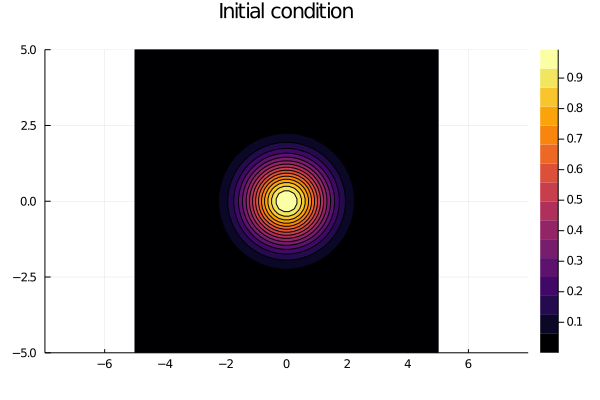

In [60]:
#prob_test.model.u0
contourf(grid_test.xRange, grid_test.yRange, prob_test.model.u0, 
         aspect_ratio=:equal, title="Initial condition")

Max: 0.7543051313832931


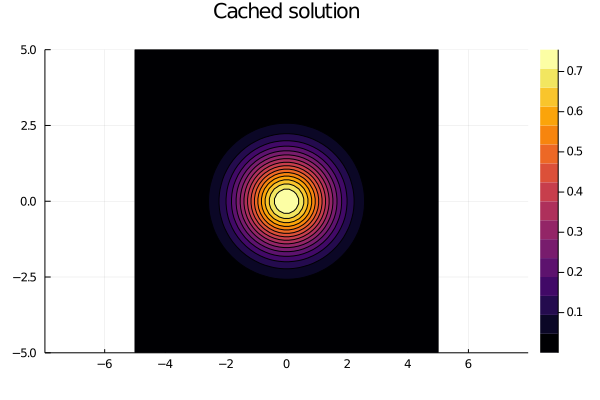

In [61]:
#prob_test.cache.u
println("Max: ", maximum(prob_test.cache.u))
contourf(grid_test.xRange, grid_test.yRange, prob_test.cache.u, 
         aspect_ratio=:equal, title="Cached solution")

Max: 0.7543051313832931


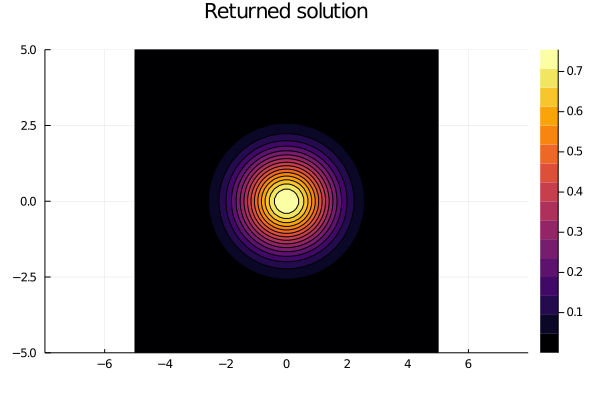

In [62]:
#sol_test.u
println("Max: ", maximum(sol_test.u))
contourf(grid_test.xRange, grid_test.yRange, sol_test.u, 
         aspect_ratio=:equal, title="Returned solution")

Max: 0.7766173699298365


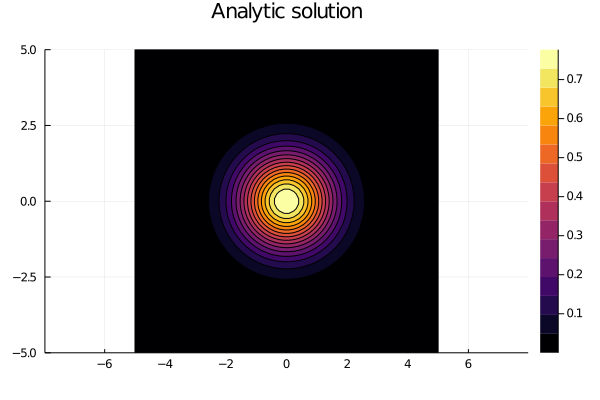

In [63]:
#sol_test.u_analytic
println("Max: ", maximum(sol_test.u_analytic))
contourf(grid_test.xRange, grid_test.yRange, sol_test.u_analytic, 
         aspect_ratio=:equal, title="Analytic solution")

Max error: 0.022312238546543406


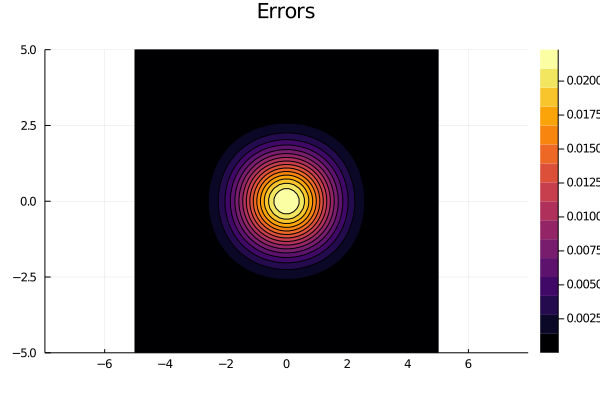

In [64]:
#sol_test.errors
println("Max error: ", maximum(sol_test.errors))
contourf(grid_test.xRange, grid_test.yRange, sol_test.errors, 
         aspect_ratio=:equal, title="Errors")

In [65]:
# sol = 0.7503074148181966 // 0.09798157946306095 + 0.00409626216077829
# ana = 0.7745194759544624 // 0.09798157946306095
maximum(uana_test(0.09798157946306095*1.20))

0.7515582339465188

## Work precision set

In [66]:
function error_vary_params(σ, nx, ny)
    grid_σ = Grid(1., 2., nx, ny)
    param_σ = Parameters(0.2, σ, (0.0, 0.02))
    u0_σ = make_gaussian(grid_σ)
    uana_test(t) = solution_gaussian(grid_σ, t, param_σ.ν)

    mod_σ = DiffusionModel(u0_σ, uana_test, grid_σ, param_σ)
    prob_σ = DiffusionProblem(mod_σ, ExplicitDiffusion())
    
    sol_timed = @timed solve(prob_σ);
    sol_σ = sol_timed[1]
    sol_time = sol_timed[2]
    
    abs_err = maximum(sol_σ.errors)
    #rel_err = abs_err/maximum(sol_σ.u_analytic)
    rel_err = maximum(sol_σ.u)/maximum(sol_σ.u_analytic)
    
    return sol_time, abs_err, rel_err
end;
function error_vector_σ(σ, error_fun)
    abs_errors = zeros(size(σ))
    rel_errors = zeros(size(σ))
    times = zeros(size(σ))
    for i in 1:length(abs_errors)
        println(σ[i])
        times[i], abs_errors[i], rel_errors[i] = error_fun(σ[i])
    end
    return times, abs_errors, rel_errors
end;

In [67]:
error_vary_σ_8x16(σ) = error_vary_params(σ, 8, 16)
error_vary_σ_16x32(σ) = error_vary_params(σ, 16, 32)
error_vary_σ_32x64(σ) = error_vary_params(σ, 32, 64)
timeerr_8x16  = error_vector_σ(range(1e-6, 5e-1, length = 40), error_vary_σ_8x16)
timeerr_16x32 = error_vector_σ(range(1e-6, 5e-1, length = 40), error_vary_σ_16x32)
timeerr_32x64 = error_vector_σ(range(1e-6, 5e-1, length = 40), error_vary_σ_32x64);

1.0e-6
0.0
3.8095238095238085e-7
7.619047619047617e-7
1.1428571428571426e-6
1.5238095238095234e-6
1.9047619047619043e-6
2.285714285714285e-6
2.666666666666666e-6
3.047619047619047e-6
3.4285714285714277e-6
3.8095238095238085e-6
4.190476190476189e-6
4.57142857142857e-6
4.952380952380951e-6
5.333333333333332e-6
5.714285714285713e-6
6.095238095238094e-6
6.4761904761904745e-6
6.857142857142855e-6
7.238095238095236e-6
7.619047619047617e-6
7.999999999999998e-6
8.380952380952379e-6
8.76190476190476e-6
9.14285714285714e-6
9.523809523809521e-6
9.904761904761902e-6
1.0285714285714283e-5
1.0666666666666664e-5
1.1047619047619045e-5
1.1428571428571426e-5
1.1809523809523806e-5
1.2190476190476187e-5
1.2571428571428568e-5
1.2952380952380949e-5
1.333333333333333e-5
1.371428571428571e-5
1.4095238095238092e-5
1.4476190476190472e-5
1.4857142857142853e-5
1.5238095238095234e-5
1.5619047619047615e-5
1.5999999999999996e-5
1.6380952380952377e-5
1.6761904761904758e-5
1.714285714285714e-5
1.752380952380952e-5
1.7

0.00017866666666666871
0.0001790476190476211
0.0001794285714285735
0.00017980952380952588
0.00018019047619047827
0.00018057142857143065
0.00018095238095238304
0.00018133333333333543
0.00018171428571428782
0.0001820952380952402
0.0001824761904761926
0.00018285714285714498
0.00018323809523809737
0.00018361904761904975
0.00018400000000000214
0.00018438095238095453
0.00018476190476190692
0.0001851428571428593
0.0001855238095238117
0.00018590476190476408
0.00018628571428571647
0.00018666666666666885
0.00018704761904762124
0.00018742857142857363
0.00018780952380952602
0.0001881904761904784
0.0001885714285714308
0.00018895238095238318
0.00018933333333333557
0.00018971428571428796
0.00019009523809524034
0.00019047619047619273
0.00019085714285714512
0.0001912380952380975
0.0001916190476190499
0.00019200000000000228
0.00019238095238095467
0.00019276190476190706
0.00019314285714285944
0.00019352380952381183
0.00019390476190476422
0.0001942857142857166
0.000194666666666669
0.00019504761904762138
0

0.0003520000000000051
0.0003523809523809575
0.00035276190476190986
0.00035314285714286225
0.00035352380952381464
0.000353904761904767
0.0003542857142857194
0.0003546666666666718
0.0003550476190476242
0.0003554285714285766
0.00035580952380952896
0.00035619047619048135
0.00035657142857143374
0.0003569523809523861
0.0003573333333333385
0.0003577142857142909
0.0003580952380952433
0.0003584761904761957
0.00035885714285714806
0.00035923809523810045
0.00035961904761905284
0.0003600000000000052
0.0003603809523809576
0.00036076190476191
0.0003611428571428624
0.0003615238095238148
0.00036190476190476716
0.00036228571428571955
0.00036266666666667194
0.00036304761904762433
0.0003634285714285767
0.0003638095238095291
0.0003641904761904815
0.0003645714285714339
0.00036495238095238627
0.00036533333333333865
0.00036571428571429104
0.00036609523809524343
0.0003664761904761958
0.0003668571428571482
0.0003672380952381006
0.000367619047619053
0.00036800000000000537
0.00036838095238095775
0.000368761904761

0.0005093333333333382
0.0005097142857142905
0.0005100952380952429
0.0005104761904761952
0.0005108571428571475
0.0005112380952380999
0.0005116190476190522
0.0005120000000000045
0.0005123809523809569
0.0005127619047619092
0.0005131428571428615
0.0005135238095238139
0.0005139047619047662
0.0005142857142857185
0.0005146666666666709
0.0005150476190476232
0.0005154285714285755
0.0005158095238095279
0.0005161904761904802
0.0005165714285714325
0.0005169523809523849
0.0005173333333333372
0.0005177142857142895
0.0005180952380952419
0.0005184761904761942
0.0005188571428571465
0.0005192380952380989
0.0005196190476190512
0.0005200000000000035
0.0005203809523809559
0.0005207619047619082
0.0005211428571428605
0.0005215238095238129
0.0005219047619047652
0.0005222857142857175
0.0005226666666666699
0.0005230476190476222
0.0005234285714285745
0.0005238095238095269
0.0005241904761904792
0.0005245714285714315
0.0005249523809523839
0.0005253333333333362
0.0005257142857142885
0.0005260952380952409
0.00052647

0.0006868571428571256
0.0006872380952380779
0.0006876190476190302
0.0006879999999999826
0.0006883809523809349
0.0006887619047618872
0.0006891428571428396
0.0006895238095237919
0.0006899047619047442
0.0006902857142856966
0.0006906666666666489
0.0006910476190476012
0.0006914285714285536
0.0006918095238095059
0.0006921904761904582
0.0006925714285714106
0.0006929523809523629
0.0006933333333333152
0.0006937142857142676
0.0006940952380952199
0.0006944761904761722
0.0006948571428571246
0.0006952380952380769
0.0006956190476190292
0.0006959999999999816
0.0006963809523809339
0.0006967619047618862
0.0006971428571428386
0.0006975238095237909
0.0006979047619047432
0.0006982857142856956
0.0006986666666666479
0.0006990476190476002
0.0006994285714285526
0.0006998095238095049
0.0007001904761904572
0.0007005714285714096
0.0007009523809523619
0.0007013333333333142
0.0007017142857142666
0.0007020952380952189
0.0007024761904761712
0.0007028571428571236
0.0007032380952380759
0.0007036190476190282
0.00070399

0.0008643809523809129
0.0008647619047618653
0.0008651428571428176
0.0008655238095237699
0.0008659047619047223
0.0008662857142856746
0.0008666666666666269
0.0008670476190475793
0.0008674285714285316
0.0008678095238094839
0.0008681904761904363
0.0008685714285713886
0.0008689523809523409
0.0008693333333332933
0.0008697142857142456
0.000870095238095198
0.0008704761904761503
0.0008708571428571026
0.000871238095238055
0.0008716190476190073
0.0008719999999999596
0.000872380952380912
0.0008727619047618643
0.0008731428571428166
0.000873523809523769
0.0008739047619047213
0.0008742857142856736
0.000874666666666626
0.0008750476190475783
0.0008754285714285306
0.000875809523809483
0.0008761904761904353
0.0008765714285713876
0.00087695238095234
0.0008773333333332923
0.0008777142857142446
0.000878095238095197
0.0008784761904761493
0.0008788571428571016
0.000879238095238054
0.0008796190476190063
0.0008799999999999586
0.000880380952380911
0.0008807619047618633
0.0008811428571428156
0.000881523809523768


0.001044571428571386
0.0010449523809523385
0.001045333333333291
0.0010457142857142434
0.0010460952380951958
0.0010464761904761483
0.0010468571428571007
0.0010472380952380532
0.0010476190476190056
0.001047999999999958
0.0010483809523809105
0.001048761904761863
0.0010491428571428154
0.0010495238095237678
0.0010499047619047202
0.0010502857142856727
0.0010506666666666251
0.0010510476190475776
0.00105142857142853
0.0010518095238094825
0.001052190476190435
0.0010525714285713873
0.0010529523809523398
0.0010533333333332922
0.0010537142857142447
0.001054095238095197
0.0010544761904761495
0.001054857142857102
0.0010552380952380544
0.0010556190476190069
0.0010559999999999593
0.0010563809523809118
0.0010567619047618642
0.0010571428571428166
0.001057523809523769
0.0010579047619047215
0.001058285714285674
0.0010586666666666264
0.0010590476190475788
0.0010594285714285313
0.0010598095238094837
0.0010601904761904362
0.0010605714285713886
0.001060952380952341
0.0010613333333332935
0.001061714285714246
0

0.0012239999999999862
0.0012243809523809386
0.001224761904761891
0.0012251428571428435
0.001225523809523796
0.0012259047619047484
0.0012262857142857008
0.0012266666666666533
0.0012270476190476057
0.0012274285714285581
0.0012278095238095106
0.001228190476190463
0.0012285714285714155
0.001228952380952368
0.0012293333333333204
0.0012297142857142728
0.0012300952380952252
0.0012304761904761777
0.0012308571428571301
0.0012312380952380826
0.001231619047619035
0.0012319999999999874
0.0012323809523809399
0.0012327619047618923
0.0012331428571428448
0.0012335238095237972
0.0012339047619047497
0.001234285714285702
0.0012346666666666545
0.001235047619047607
0.0012354285714285594
0.0012358095238095119
0.0012361904761904643
0.0012365714285714167
0.0012369523809523692
0.0012373333333333216
0.001237714285714274
0.0012380952380952265
0.001238476190476179
0.0012388571428571314
0.0012392380952380838
0.0012396190476190363
0.0012399999999999887
0.0012403809523809412
0.0012407619047618936
0.00124114285714284

0.0014034285714285863
0.0014038095238095387
0.0014041904761904912
0.0014045714285714436
0.001404952380952396
0.0014053333333333485
0.001405714285714301
0.0014060952380952534
0.0014064761904762058
0.0014068571428571583
0.0014072380952381107
0.0014076190476190631
0.0014080000000000156
0.001408380952380968
0.0014087619047619205
0.001409142857142873
0.0014095238095238253
0.0014099047619047778
0.0014102857142857302
0.0014106666666666827
0.0014110476190476351
0.0014114285714285876
0.00141180952380954
0.0014121904761904924
0.0014125714285714449
0.0014129523809523973
0.0014133333333333498
0.0014137142857143022
0.0014140952380952546
0.001414476190476207
0.0014148571428571595
0.001415238095238112
0.0014156190476190644
0.0014160000000000169
0.0014163809523809693
0.0014167619047619217
0.0014171428571428742
0.0014175238095238266
0.001417904761904779
0.0014182857142857315
0.001418666666666684
0.0014190476190476364
0.0014194285714285888
0.0014198095238095413
0.0014201904761904937
0.001420571428571446

0.0015828571428571864
0.0015832380952381388
0.0015836190476190913
0.0015840000000000437
0.0015843809523809961
0.0015847619047619486
0.001585142857142901
0.0015855238095238535
0.001585904761904806
0.0015862857142857584
0.0015866666666667108
0.0015870476190476632
0.0015874285714286157
0.0015878095238095681
0.0015881904761905206
0.001588571428571473
0.0015889523809524255
0.001589333333333378
0.0015897142857143303
0.0015900952380952828
0.0015904761904762352
0.0015908571428571877
0.00159123809523814
0.0015916190476190925
0.001592000000000045
0.0015923809523809974
0.0015927619047619499
0.0015931428571429023
0.0015935238095238548
0.0015939047619048072
0.0015942857142857596
0.001594666666666712
0.0015950476190476645
0.001595428571428617
0.0015958095238095694
0.0015961904761905218
0.0015965714285714743
0.0015969523809524267
0.0015973333333333792
0.0015977142857143316
0.001598095238095284
0.0015984761904762365
0.001598857142857189
0.0015992380952381414
0.0015996190476190938
0.0016000000000000463

0.0017622857142857865
0.001762666666666739
0.0017630476190476914
0.0017634285714286438
0.0017638095238095963
0.0017641904761905487
0.0017645714285715011
0.0017649523809524536
0.001765333333333406
0.0017657142857143585
0.001766095238095311
0.0017664761904762633
0.0017668571428572158
0.0017672380952381682
0.0017676190476191207
0.0017680000000000731
0.0017683809523810256
0.001768761904761978
0.0017691428571429304
0.0017695238095238829
0.0017699047619048353
0.0017702857142857878
0.0017706666666667402
0.0017710476190476927
0.001771428571428645
0.0017718095238095975
0.00177219047619055
0.0017725714285715024
0.0017729523809524549
0.0017733333333334073
0.0017737142857143597
0.0017740952380953122
0.0017744761904762646
0.001774857142857217
0.0017752380952381695
0.001775619047619122
0.0017760000000000744
0.0017763809523810268
0.0017767619047619793
0.0017771428571429317
0.0017775238095238842
0.0017779047619048366
0.001778285714285789
0.0017786666666667415
0.001779047619047694
0.0017794285714286464

0.001961904761904861
0.001962285714285813
0.0019626666666667653
0.0019630476190477175
0.0019634285714286697
0.001963809523809622
0.001964190476190574
0.0019645714285715264
0.0019649523809524786
0.001965333333333431
0.001965714285714383
0.0019660952380953353
0.0019664761904762875
0.0019668571428572397
0.001967238095238192
0.001967619047619144
0.0019680000000000964
0.0019683809523810486
0.001968761904762001
0.001969142857142953
0.0019695238095239053
0.0019699047619048575
0.0019702857142858098
0.001970666666666762
0.001971047619047714
0.0019714285714286664
0.0019718095238096187
0.001972190476190571
0.001972571428571523
0.0019729523809524753
0.0019733333333334276
0.00197371428571438
0.001974095238095332
0.0019744761904762842
0.0019748571428572365
0.0019752380952381887
0.001975619047619141
0.001976000000000093
0.0019763809523810454
0.0019767619047619976
0.00197714285714295
0.001977523809523902
0.0019779047619048543
0.0019782857142858065
0.0019786666666667587
0.001979047619047711
0.001979428

0.002143619047619072
0.0021440000000000244
0.0021443809523809766
0.002144761904761929
0.002145142857142881
0.0021455238095238333
0.0021459047619047855
0.0021462857142857377
0.00214666666666669
0.002147047619047642
0.0021474285714285944
0.0021478095238095466
0.002148190476190499
0.002148571428571451
0.0021489523809524033
0.0021493333333333555
0.0021497142857143077
0.00215009523809526
0.002150476190476212
0.0021508571428571644
0.0021512380952381166
0.002151619047619069
0.002152000000000021
0.0021523809523809733
0.0021527619047619255
0.0021531428571428778
0.00215352380952383
0.002153904761904782
0.0021542857142857344
0.0021546666666666867
0.002155047619047639
0.002155428571428591
0.0021558095238095433
0.0021561904761904956
0.002156571428571448
0.0021569523809524
0.0021573333333333522
0.0021577142857143045
0.0021580952380952567
0.002158476190476209
0.002158857142857161
0.0021592380952381134
0.0021596190476190656
0.002160000000000018
0.00216038095238097
0.0021607619047619223
0.0021611428571

0.0023253333333332835
0.0023257142857142357
0.002326095238095188
0.00232647619047614
0.0023268571428570924
0.0023272380952380446
0.002327619047618997
0.002327999999999949
0.0023283809523809013
0.0023287619047618535
0.0023291428571428057
0.002329523809523758
0.00232990476190471
0.0023302857142856624
0.0023306666666666146
0.002331047619047567
0.002331428571428519
0.0023318095238094713
0.0023321904761904235
0.0023325714285713757
0.002332952380952328
0.00233333333333328
0.0023337142857142324
0.0023340952380951846
0.002334476190476137
0.002334857142857089
0.0023352380952380413
0.0023356190476189935
0.0023359999999999458
0.002336380952380898
0.00233676190476185
0.0023371428571428024
0.0023375238095237547
0.002337904761904707
0.002338285714285659
0.0023386666666666113
0.0023390476190475636
0.002339428571428516
0.002339809523809468
0.0023401904761904202
0.0023405714285713725
0.0023409523809523247
0.002341333333333277
0.002341714285714229
0.0023420952380951814
0.0023424761904761336
0.0023428571

0.002507047619047495
0.002507428571428447
0.0025078095238093992
0.0025081904761903515
0.0025085714285713037
0.002508952380952256
0.002509333333333208
0.0025097142857141604
0.0025100952380951126
0.002510476190476065
0.002510857142857017
0.0025112380952379693
0.0025116190476189215
0.0025119999999998737
0.002512380952380826
0.002512761904761778
0.0025131428571427304
0.0025135238095236826
0.002513904761904635
0.002514285714285587
0.0025146666666665393
0.0025150476190474915
0.0025154285714284437
0.002515809523809396
0.002516190476190348
0.0025165714285713004
0.0025169523809522526
0.002517333333333205
0.002517714285714157
0.0025180952380951093
0.0025184761904760615
0.0025188571428570138
0.002519238095237966
0.002519619047618918
0.0025199999999998704
0.0025203809523808227
0.002520761904761775
0.002521142857142727
0.0025215238095236793
0.0025219047619046316
0.002522285714285584
0.002522666666666536
0.0025230476190474882
0.0025234285714284405
0.0025238095238093927
0.002524190476190345
0.0025245

0.002688761904761706
0.0026891428571426583
0.0026895238095236106
0.002689904761904563
0.002690285714285515
0.0026906666666664672
0.0026910476190474195
0.0026914285714283717
0.002691809523809324
0.002692190476190276
0.0026925714285712284
0.0026929523809521806
0.002693333333333133
0.002693714285714085
0.0026940952380950373
0.0026944761904759895
0.0026948571428569417
0.002695238095237894
0.002695619047618846
0.0026959999999997984
0.0026963809523807506
0.002696761904761703
0.002697142857142655
0.0026975238095236073
0.0026979047619045595
0.0026982857142855117
0.002698666666666464
0.002699047619047416
0.0026994285714283684
0.0026998095238093206
0.002700190476190273
0.002700571428571225
0.0027009523809521773
0.0027013333333331295
0.0027017142857140818
0.002702095238095034
0.002702476190475986
0.0027028571428569384
0.0027032380952378907
0.002703619047618843
0.002703999999999795
0.0027043809523807473
0.0027047619047616996
0.002705142857142652
0.002705523809523604
0.0027059047619045562
0.0027062

0.002844190476190214
0.002844571428571166
0.0028449523809521184
0.0028453333333330706
0.002845714285714023
0.002846095238094975
0.0028464761904759273
0.0028468571428568795
0.0028472380952378317
0.002847619047618784
0.002847999999999736
0.0028483809523806884
0.0028487619047616406
0.002849142857142593
0.002849523809523545
0.0028499047619044973
0.0028502857142854495
0.0028506666666664017
0.002851047619047354
0.002851428571428306
0.0028518095238092584
0.0028521904761902106
0.002852571428571163
0.002852952380952115
0.0028533333333330673
0.0028537142857140195
0.0028540952380949718
0.002854476190475924
0.002854857142856876
0.0028552380952378284
0.0028556190476187807
0.002855999999999733
0.002856380952380685
0.0028567619047616373
0.0028571428571425896
0.002857523809523542
0.002857904761904494
0.0028582857142854462
0.0028586666666663985
0.0028590476190473507
0.002859428571428303
0.002859809523809255
0.0028601904761902074
0.0028605714285711596
0.002860952380952112
0.002861333333333064
0.00286171

0.0030259047619044252
0.0030262857142853775
0.0030266666666663297
0.003027047619047282
0.003027428571428234
0.0030278095238091864
0.0030281904761901386
0.003028571428571091
0.003028952380952043
0.0030293333333329953
0.0030297142857139475
0.0030300952380948997
0.003030476190475852
0.003030857142856804
0.0030312380952377564
0.0030316190476187086
0.003031999999999661
0.003032380952380613
0.0030327619047615653
0.0030331428571425175
0.0030335238095234697
0.003033904761904422
0.003034285714285374
0.0030346666666663264
0.0030350476190472786
0.003035428571428231
0.003035809523809183
0.0030361904761901353
0.0030365714285710875
0.0030369523809520398
0.003037333333332992
0.003037714285713944
0.0030380952380948964
0.0030384761904758487
0.003038857142856801
0.003039238095237753
0.0030396190476187053
0.0030399999999996576
0.00304038095238061
0.003040761904761562
0.0030411428571425142
0.0030415238095234665
0.0030419047619044187
0.003042285714285371
0.003042666666666323
0.0030430476190472754
0.0030434

0.0032076190476186366
0.003207999999999589
0.003208380952380541
0.0032087619047614932
0.0032091428571424455
0.0032095238095233977
0.00320990476190435
0.003210285714285302
0.0032106666666662544
0.0032110476190472066
0.003211428571428159
0.003211809523809111
0.0032121904761900633
0.0032125714285710155
0.0032129523809519677
0.00321333333333292
0.003213714285713872
0.0032140952380948244
0.0032144761904757766
0.003214857142856729
0.003215238095237681
0.0032156190476186333
0.0032159999999995855
0.0032163809523805377
0.00321676190476149
0.003217142857142442
0.0032175238095233944
0.0032179047619043466
0.003218285714285299
0.003218666666666251
0.0032190476190472033
0.0032194285714281555
0.0032198095238091078
0.00322019047619006
0.003220571428571012
0.0032209523809519644
0.0032213333333329167
0.003221714285713869
0.003222095238094821
0.0032224761904757733
0.0032228571428567256
0.003223238095237678
0.00322361904761863
0.0032239999999995822
0.0032243809523805345
0.0032247619047614867
0.00322514285

0.003389333333332848
0.0033897142857138
0.0033900952380947523
0.0033904761904757046
0.003390857142856657
0.003391238095237609
0.0033916190476185612
0.0033919999999995135
0.0033923809523804657
0.003392761904761418
0.00339314285714237
0.0033935238095233224
0.0033939047619042746
0.003394285714285227
0.003394666666666179
0.0033950476190471313
0.0033954285714280835
0.0033958095238090357
0.003396190476189988
0.00339657142857094
0.0033969523809518924
0.0033973333333328446
0.003397714285713797
0.003398095238094749
0.0033984761904757013
0.0033988571428566535
0.0033992380952376057
0.003399619047618558
0.00339999999999951
0.0034003809523804624
0.0034007619047614146
0.003401142857142367
0.003401523809523319
0.0034019047619042713
0.0034022857142852235
0.0034026666666661758
0.003403047619047128
0.00340342857142808
0.0034038095238090324
0.0034041904761899847
0.003404571428570937
0.003404952380951889
0.0034053333333328413
0.0034057142857137936
0.003406095238094746
0.003406476190475698
0.00340685714285

0.003571047619047059
0.0035714285714280114
0.0035718095238089637
0.003572190476189916
0.003572571428570868
0.0035729523809518203
0.0035733333333327726
0.003573714285713725
0.003574095238094677
0.0035744761904756292
0.0035748571428565815
0.0035752380952375337
0.003575619047618486
0.003575999999999438
0.0035763809523803904
0.0035767619047613426
0.003577142857142295
0.003577523809523247
0.0035779047619041993
0.0035782857142851515
0.0035786666666661037
0.003579047619047056
0.003579428571428008
0.0035798095238089604
0.0035801904761899126
0.003580571428570865
0.003580952380951817
0.0035813333333327693
0.0035817142857137215
0.0035820952380946737
0.003582476190475626
0.003582857142856578
0.0035832380952375304
0.0035836190476184826
0.003583999999999435
0.003584380952380387
0.0035847619047613393
0.0035851428571422915
0.0035855238095232438
0.003585904761904196
0.003586285714285148
0.0035866666666661004
0.0035870476190470527
0.003587428571428005
0.003587809523808957
0.0035881904761899093
0.0035885

0.0038716190476183647
0.003871999999999317
0.003872380952380269
0.0038727619047612214
0.0038731428571421736
0.003873523809523126
0.003873904761904078
0.0038742857142850303
0.0038746666666659825
0.0038750476190469348
0.003875428571427887
0.003875809523808839
0.0038761904761897914
0.0038765714285707437
0.003876952380951696
0.003877333333332648
0.0038777142857136003
0.0038780952380945526
0.003878476190475505
0.003878857142856457
0.0038792380952374092
0.0038796190476183615
0.0038799999999993137
0.003880380952380266
0.003880761904761218
0.0038811428571421704
0.0038815238095231226
0.003881904761904075
0.003882285714285027
0.0038826666666659793
0.0038830476190469315
0.0038834285714278837
0.003883809523808836
0.003884190476189788
0.0038845714285707404
0.0038849523809516926
0.003885333333332645
0.003885714285713597
0.0038860952380945493
0.0038864761904755015
0.0038868571428564537
0.003887238095237406
0.003887619047618358
0.0038879999999993104
0.0038883809523802626
0.003888761904761215
0.0038891

0.004056380952380194
0.004056761904761146
0.004057142857142098
0.0040575238095230505
0.004057904761904003
0.004058285714284955
0.004058666666665907
0.0040590476190468594
0.004059428571427812
0.004059809523808764
0.004060190476189716
0.004060571428570668
0.0040609523809516206
0.004061333333332573
0.004061714285713525
0.004062095238094477
0.0040624761904754295
0.004062857142856382
0.004063238095237334
0.004063619047618286
0.004063999999999238
0.004064380952380191
0.004064761904761143
0.004065142857142095
0.004065523809523047
0.0040659047619039995
0.004066285714284952
0.004066666666665904
0.004067047619046856
0.004067428571427808
0.004067809523808761
0.004068190476189713
0.004068571428570665
0.004068952380951617
0.0040693333333325695
0.004069714285713522
0.004070095238094474
0.004070476190475426
0.004070857142856378
0.004071238095237331
0.004071619047618283
0.004071999999999235
0.004072380952380187
0.0040727619047611395
0.004073142857142092
0.004073523809523044
0.004073904761903996
0.0040

0.0042419047619039274
0.00424228571428488
0.004242666666665832
0.004243047619046784
0.004243428571427736
0.0042438095238086886
0.004244190476189641
0.004244571428570593
0.004244952380951545
0.0042453333333324975
0.00424571428571345
0.004246095238094402
0.004246476190475354
0.004246857142856306
0.004247238095237259
0.004247619047618211
0.004247999999999163
0.004248380952380115
0.0042487619047610675
0.00424914285714202
0.004249523809522972
0.004249904761903924
0.004250285714284876
0.004250666666665829
0.004251047619046781
0.004251428571427733
0.004251809523808685
0.0042521904761896375
0.00425257142857059
0.004252952380951542
0.004253333333332494
0.004253714285713446
0.004254095238094399
0.004254476190475351
0.004254857142856303
0.004255238095237255
0.0042556190476182075
0.00425599999999916
0.004256380952380112
0.004256761904761064
0.0042571428571420164
0.004257523809522969
0.004257904761903921
0.004258285714284873
0.004258666666665825
0.0042590476190467776
0.00425942857142773
0.004259809

0.004427428571427661
0.004427809523808613
0.0044281904761895655
0.004428571428570518
0.00442895238095147
0.004429333333332422
0.004429714285713374
0.004430095238094327
0.004430476190475279
0.004430857142856231
0.004431238095237183
0.0044316190476181355
0.004431999999999088
0.00443238095238004
0.004432761904760992
0.004433142857141944
0.004433523809522897
0.004433904761903849
0.004434285714284801
0.004434666666665753
0.0044350476190467055
0.004435428571427658
0.00443580952380861
0.004436190476189562
0.004436571428570514
0.004436952380951467
0.004437333333332419
0.004437714285713371
0.004438095238094323
0.0044384761904752755
0.004438857142856228
0.00443923809523718
0.004439619047618132
0.0044399999999990844
0.004440380952380037
0.004440761904760989
0.004441142857141941
0.004441523809522893
0.0044419047619038456
0.004442285714284798
0.00444266666666575
0.004443047619046702
0.0044434285714276545
0.004443809523808607
0.004444190476189559
0.004444571428570511
0.004444952380951463
0.004445333

0.004612952380951395
0.004613333333332347
0.004613714285713299
0.004614095238094251
0.0046144761904752035
0.004614857142856156
0.004615238095237108
0.00461561904761806
0.004615999999999012
0.004616380952379965
0.004616761904760917
0.004617142857141869
0.004617523809522821
0.0046179047619037735
0.004618285714284726
0.004618666666665678
0.00461904761904663
0.004619428571427582
0.004619809523808535
0.004620190476189487
0.004620571428570439
0.004620952380951391
0.0046213333333323435
0.004621714285713296
0.004622095238094248
0.0046224761904752
0.0046228571428561524
0.004623238095237105
0.004623619047618057
0.004623999999999009
0.004624380952379961
0.0046247619047609136
0.004625142857141866
0.004625523809522818
0.00462590476190377
0.0046262857142847225
0.004626666666665675
0.004627047619046627
0.004627428571427579
0.004627809523808531
0.004628190476189484
0.004628571428570436
0.004628952380951388
0.00462933333333234
0.0046297142857132925
0.004630095238094245
0.004630476190475197
0.0046308571

0.0049344761904750725
0.004934857142856025
0.004935238095236977
0.004935619047617929
0.004935999999998881
0.004936380952379834
0.004936761904760786
0.004937142857141738
0.00493752380952269
0.0049379047619036425
0.004938285714284595
0.004938666666665547
0.004939047619046499
0.004939428571427451
0.004939809523808404
0.004940190476189356
0.004940571428570308
0.00494095238095126
0.0049413333333322125
0.004941714285713165
0.004942095238094117
0.004942476190475069
0.0049428571428560214
0.004943238095236974
0.004943619047617926
0.004943999999998878
0.00494438095237983
0.0049447619047607826
0.004945142857141735
0.004945523809522687
0.004945904761903639
0.0049462857142845915
0.004946666666665544
0.004947047619046496
0.004947428571427448
0.0049478095238084
0.004948190476189353
0.004948571428570305
0.004948952380951257
0.004949333333332209
0.0049497142857131615
0.004950095238094114
0.004950476190475066
0.004950857142856018
0.00495123809523697
0.004951619047617923
0.004951999999998875
0.0049523809

0.005119999999998806
0.005120380952379758
0.0051207619047607105
0.005121142857141663
0.005121523809522615
0.005121904761903567
0.005122285714284519
0.005122666666665472
0.005123047619046424
0.005123428571427376
0.005123809523808328
0.0051241904761892805
0.005124571428570233
0.005124952380951185
0.005125333333332137
0.0051257142857130894
0.005126095238094042
0.005126476190474994
0.005126857142855946
0.005127238095236898
0.0051276190476178506
0.005127999999998803
0.005128380952379755
0.005128761904760707
0.0051291428571416595
0.005129523809522612
0.005129904761903564
0.005130285714284516
0.005130666666665468
0.005131047619046421
0.005131428571427373
0.005131809523808325
0.005132190476189277
0.0051325714285702295
0.005132952380951182
0.005133333333332134
0.005133714285713086
0.005134095238094038
0.005134476190474991
0.005134857142855943
0.005135238095236895
0.005135619047617847
0.0051359999999987995
0.005136380952379752
0.005136761904760704
0.005137142857141656
0.005137523809522608
0.0051

0.00530552380952254
0.005305904761903492
0.005306285714284444
0.005306666666665396
0.0053070476190463485
0.005307428571427301
0.005307809523808253
0.005308190476189205
0.0053085714285701574
0.00530895238095111
0.005309333333332062
0.005309714285713014
0.005310095238093966
0.0053104761904749186
0.005310857142855871
0.005311238095236823
0.005311619047617775
0.0053119999999987275
0.00531238095237968
0.005312761904760632
0.005313142857141584
0.005313523809522536
0.005313904761903489
0.005314285714284441
0.005314666666665393
0.005315047619046345
0.0053154285714272975
0.00531580952380825
0.005316190476189202
0.005316571428570154
0.005316952380951106
0.005317333333332059
0.005317714285713011
0.005318095238093963
0.005318476190474915
0.0053188571428558675
0.00531923809523682
0.005319619047617772
0.005319999999998724
0.005320380952379676
0.005320761904760629
0.005321142857141581
0.005321523809522533
0.005321904761903485
0.0053222857142844375
0.00532266666666539
0.005323047619046342
0.0053234285

0.005491047619046273
0.0054914285714272254
0.005491809523808178
0.00549219047618913
0.005492571428570082
0.005492952380951034
0.0054933333333319866
0.005493714285712939
0.005494095238093891
0.005494476190474843
0.0054948571428557955
0.005495238095236748
0.0054956190476177
0.005495999999998652
0.005496380952379604
0.005496761904760557
0.005497142857141509
0.005497523809522461
0.005497904761903413
0.0054982857142843655
0.005498666666665318
0.00549904761904627
0.005499428571427222
0.005499809523808174
0.005500190476189127
0.005500571428570079
0.005500952380951031
0.005501333333331983
0.0055017142857129355
0.005502095238093888
0.00550247619047484
0.005502857142855792
0.005503238095236744
0.005503619047617697
0.005503999999998649
0.005504380952379601
0.005504761904760553
0.0055051428571415055
0.005505523809522458
0.00550590476190341
0.005506285714284362
0.0055066666666653144
0.005507047619046267
0.005507428571427219
0.005507809523808171
0.005508190476189123
0.0055085714285700756
0.005508952

0.005676571428570007
0.005676952380950959
0.005677333333331911
0.0056777142857128635
0.005678095238093816
0.005678476190474768
0.00567885714285572
0.005679238095236672
0.005679619047617625
0.005679999999998577
0.005680380952379529
0.005680761904760481
0.0056811428571414335
0.005681523809522386
0.005681904761903338
0.00568228571428429
0.005682666666665242
0.005683047619046195
0.005683428571427147
0.005683809523808099
0.005684190476189051
0.0056845714285700035
0.005684952380950956
0.005685333333331908
0.00568571428571286
0.005686095238093812
0.005686476190474765
0.005686857142855717
0.005687238095236669
0.005687619047617621
0.0056879999999985735
0.005688380952379526
0.005688761904760478
0.00568914285714143
0.0056895238095223824
0.005689904761903335
0.005690285714284287
0.005690666666665239
0.005691047619046191
0.0056914285714271436
0.005691809523808096
0.005692190476189048
0.00569257142857
0.0056929523809509525
0.005693333333331905
0.005693714285712857
0.005694095238093809
0.005694476190

0.005926095238093714
0.005926476190474666
0.005926857142855619
0.005927238095236571
0.005927619047617523
0.005927999999998475
0.0059283809523794275
0.00592876190476038
0.005929142857141332
0.005929523809522284
0.005929904761903236
0.005930285714284189
0.005930666666665141
0.005931047619046093
0.005931428571427045
0.0059318095238079975
0.00593219047618895
0.005932571428569902
0.005932952380950854
0.0059333333333318064
0.005933714285712759
0.005934095238093711
0.005934476190474663
0.005934857142855615
0.0059352380952365676
0.00593561904761752
0.005935999999998472
0.005936380952379424
0.0059367619047603765
0.005937142857141329
0.005937523809522281
0.005937904761903233
0.005938285714284185
0.005938666666665138
0.00593904761904609
0.005939428571427042
0.005939809523807994
0.0059401904761889465
0.005940571428569899
0.005940952380950851
0.005941333333331803
0.005941714285712755
0.005942095238093708
0.00594247619047466
0.005942857142855612
0.005943238095236564
0.0059436190476175165
0.005943999

0.006111619047617448
0.0061119999999984
0.006112380952379352
0.006112761904760304
0.006113142857141257
0.006113523809522209
0.006113904761903161
0.006114285714284113
0.0061146666666650655
0.006115047619046018
0.00611542857142697
0.006115809523807922
0.0061161904761888744
0.006116571428569827
0.006116952380950779
0.006117333333331731
0.006117714285712683
0.0061180952380936356
0.006118476190474588
0.00611885714285554
0.006119238095236492
0.0061196190476174445
0.006119999999998397
0.006120380952379349
0.006120761904760301
0.006121142857141253
0.006121523809522206
0.006121904761903158
0.00612228571428411
0.006122666666665062
0.0061230476190460145
0.006123428571426967
0.006123809523807919
0.006124190476188871
0.006124571428569823
0.006124952380950776
0.006125333333331728
0.00612571428571268
0.006126095238093632
0.0061264761904745845
0.006126857142855537
0.006127238095236489
0.006127619047617441
0.006127999999998393
0.006128380952379346
0.006128761904760298
0.00612914285714125
0.006129523809

0.006297142857141181
0.0062975238095221335
0.006297904761903086
0.006298285714284038
0.00629866666666499
0.0062990476190459424
0.006299428571426895
0.006299809523807847
0.006300190476188799
0.006300571428569751
0.0063009523809507036
0.006301333333331656
0.006301714285712608
0.00630209523809356
0.0063024761904745125
0.006302857142855465
0.006303238095236417
0.006303619047617369
0.006303999999998321
0.006304380952379274
0.006304761904760226
0.006305142857141178
0.00630552380952213
0.0063059047619030825
0.006306285714284035
0.006306666666664987
0.006307047619045939
0.006307428571426891
0.006307809523807844
0.006308190476188796
0.006308571428569748
0.0063089523809507
0.0063093333333316525
0.006309714285712605
0.006310095238093557
0.006310476190474509
0.006310857142855461
0.006311238095236414
0.006311619047617366
0.006311999999998318
0.00631238095237927
0.0063127619047602225
0.006313142857141175
0.006313523809522127
0.006313904761903079
0.0063142857142840314
0.006314666666664984
0.006315047

0.006482666666664915
0.006483047619045867
0.006483428571426819
0.0064838095238077716
0.006484190476188724
0.006484571428569676
0.006484952380950628
0.0064853333333315805
0.006485714285712533
0.006486095238093485
0.006486476190474437
0.006486857142855389
0.006487238095236342
0.006487619047617294
0.006487999999998246
0.006488380952379198
0.0064887619047601505
0.006489142857141103
0.006489523809522055
0.006489904761903007
0.006490285714283959
0.006490666666664912
0.006491047619045864
0.006491428571426816
0.006491809523807768
0.0064921904761887205
0.006492571428569673
0.006492952380950625
0.006493333333331577
0.006493714285712529
0.006494095238093482
0.006494476190474434
0.006494857142855386
0.006495238095236338
0.0064956190476172905
0.006495999999998243
0.006496380952379195
0.006496761904760147
0.0064971428571410994
0.006497523809522052
0.006497904761903004
0.006498285714283956
0.006498666666664908
0.0064990476190458606
0.006499428571426813
0.006499809523807765
0.006500190476188717
0.0065

0.006667809523807696
0.0066681904761886485
0.006668571428569601
0.006668952380950553
0.006669333333331505
0.006669714285712457
0.00667009523809341
0.006670476190474362
0.006670857142855314
0.006671238095236266
0.0066716190476172185
0.006671999999998171
0.006672380952379123
0.006672761904760075
0.006673142857141027
0.00667352380952198
0.006673904761902932
0.006674285714283884
0.006674666666664836
0.0066750476190457885
0.006675428571426741
0.006675809523807693
0.006676190476188645
0.006676571428569597
0.00667695238095055
0.006677333333331502
0.006677714285712454
0.006678095238093406
0.0066784761904743585
0.006678857142855311
0.006679238095236263
0.006679619047617215
0.0066799999999981674
0.00668038095237912
0.006680761904760072
0.006681142857141024
0.006681523809521976
0.0066819047619029286
0.006682285714283881
0.006682666666664833
0.006683047619045785
0.0066834285714267375
0.00668380952380769
0.006684190476188642
0.006684571428569594
0.006684952380950546
0.006685333333331499
0.006685714

0.006929904761902827
0.006930285714283779
0.0069306666666647315
0.006931047619045684
0.006931428571426636
0.006931809523807588
0.00693219047618854
0.006932571428569493
0.006932952380950445
0.006933333333331397
0.006933714285712349
0.0069340952380933015
0.006934476190474254
0.006934857142855206
0.006935238095236158
0.00693561904761711
0.006935999999998063
0.006936380952379015
0.006936761904759967
0.006937142857140919
0.0069375238095218715
0.006937904761902824
0.006938285714283776
0.006938666666664728
0.0069390476190456804
0.006939428571426633
0.006939809523807585
0.006940190476188537
0.006940571428569489
0.0069409523809504416
0.006941333333331394
0.006941714285712346
0.006942095238093298
0.0069424761904742505
0.006942857142855203
0.006943238095236155
0.006943619047617107
0.006943999999998059
0.006944380952379012
0.006944761904759964
0.006945142857140916
0.006945523809521868
0.0069459047619028205
0.006946285714283773
0.006946666666664725
0.006947047619045677
0.006947428571426629
0.006947

0.007115428571426561
0.007115809523807513
0.007116190476188465
0.007116571428569417
0.0071169523809503695
0.007117333333331322
0.007117714285712274
0.007118095238093226
0.007118476190474178
0.007118857142855131
0.007119238095236083
0.007119619047617035
0.007119999999997987
0.0071203809523789395
0.007120761904759892
0.007121142857140844
0.007121523809521796
0.0071219047619027484
0.007122285714283701
0.007122666666664653
0.007123047619045605
0.007123428571426557
0.0071238095238075096
0.007124190476188462
0.007124571428569414
0.007124952380950366
0.0071253333333313185
0.007125714285712271
0.007126095238093223
0.007126476190474175
0.007126857142855127
0.00712723809523608
0.007127619047617032
0.007127999999997984
0.007128380952378936
0.0071287619047598885
0.007129142857140841
0.007129523809521793
0.007129904761902745
0.007130285714283697
0.00713066666666465
0.007131047619045602
0.007131428571426554
0.007131809523807506
0.0071321904761884585
0.007132571428569411
0.007132952380950363
0.007133

0.007300952380950294
0.007301333333331246
0.007301714285712199
0.007302095238093151
0.007302476190474103
0.007302857142855055
0.0073032380952360075
0.00730361904761696
0.007303999999997912
0.007304380952378864
0.0073047619047598164
0.007305142857140769
0.007305523809521721
0.007305904761902673
0.007306285714283625
0.0073066666666645776
0.00730704761904553
0.007307428571426482
0.007307809523807434
0.0073081904761883865
0.007308571428569339
0.007308952380950291
0.007309333333331243
0.007309714285712195
0.007310095238093148
0.0073104761904741
0.007310857142855052
0.007311238095236004
0.0073116190476169565
0.007311999999997909
0.007312380952378861
0.007312761904759813
0.007313142857140765
0.007313523809521718
0.00731390476190267
0.007314285714283622
0.007314666666664574
0.0073150476190455265
0.007315428571426479
0.007315809523807431
0.007316190476188383
0.007316571428569335
0.007316952380950288
0.00731733333333124
0.007317714285712192
0.007318095238093144
0.0073184761904740965
0.0073188571

0.007486476190474028
0.00748685714285498
0.007487238095235932
0.0074876190476168844
0.007487999999997837
0.007488380952378789
0.007488761904759741
0.007489142857140693
0.0074895238095216456
0.007489904761902598
0.00749028571428355
0.007490666666664502
0.0074910476190454545
0.007491428571426407
0.007491809523807359
0.007492190476188311
0.007492571428569263
0.007492952380950216
0.007493333333331168
0.00749371428571212
0.007494095238093072
0.0074944761904740245
0.007494857142854977
0.007495238095235929
0.007495619047616881
0.007495999999997833
0.007496380952378786
0.007496761904759738
0.00749714285714069
0.007497523809521642
0.0074979047619025945
0.007498285714283547
0.007498666666664499
0.007499047619045451
0.007499428571426403
0.007499809523807356
0.007500190476188308
0.00750057142856926
0.007500952380950212
0.0075013333333311645
0.007501714285712117
0.007502095238093069
0.007502476190474021
0.0075028571428549734
0.007503238095235926
0.007503619047616878
0.00750399999999783
0.0075043809

0.007671999999997761
0.0076723809523787136
0.007672761904759666
0.007673142857140618
0.00767352380952157
0.0076739047619025225
0.007674285714283475
0.007674666666664427
0.007675047619045379
0.007675428571426331
0.007675809523807284
0.007676190476188236
0.007676571428569188
0.00767695238095014
0.0076773333333310925
0.007677714285712045
0.007678095238092997
0.007678476190473949
0.007678857142854901
0.007679238095235854
0.007679619047616806
0.007679999999997758
0.00768038095237871
0.0076807619047596625
0.007681142857140615
0.007681523809521567
0.007681904761902519
0.007682285714283471
0.007682666666664424
0.007683047619045376
0.007683428571426328
0.00768380952380728
0.0076841904761882325
0.007684571428569185
0.007684952380950137
0.007685333333331089
0.0076857142857120414
0.007686095238092994
0.007686476190473946
0.007686857142854898
0.00768723809523585
0.0076876190476168026
0.007687999999997755
0.007688380952378707
0.007688761904759659
0.0076891428571406115
0.007689523809521564
0.00768990

0.007983999999998024
0.007984380952378977
0.00798476190475993
0.007985142857140883
0.007985523809521836
0.00798590476190279
0.007986285714283742
0.007986666666664696
0.007987047619045649
0.007987428571426602
0.007987809523807555
0.007988190476188508
0.007988571428569461
0.007988952380950414
0.007989333333331367
0.00798971428571232
0.007990095238093273
0.007990476190474226
0.00799085714285518
0.007991238095236133
0.007991619047617086
0.007991999999998039
0.007992380952378992
0.007992761904759945
0.007993142857140898
0.007993523809521851
0.007993904761902804
0.007994285714283757
0.00799466666666471
0.007995047619045664
0.007995428571426617
0.00799580952380757
0.007996190476188523
0.007996571428569476
0.007996952380950429
0.007997333333331382
0.007997714285712335
0.007998095238093288
0.007998476190474241
0.007998857142855195
0.007999238095236148
0.0079996190476171
0.007999999999998054
0.008000380952379007
0.00800076190475996
0.008001142857140913
0.008001523809521866
0.00800190476190282
0.

0.008171809523807898
0.008172190476188852
0.008172571428569805
0.008172952380950758
0.00817333333333171
0.008173714285712664
0.008174095238093617
0.00817447619047457
0.008174857142855523
0.008175238095236476
0.00817561904761743
0.008175999999998382
0.008176380952379336
0.008176761904760289
0.008177142857141242
0.008177523809522195
0.008177904761903148
0.008178285714284101
0.008178666666665054
0.008179047619046007
0.00817942857142696
0.008179809523807913
0.008180190476188866
0.00818057142856982
0.008180952380950773
0.008181333333331726
0.008181714285712679
0.008182095238093632
0.008182476190474585
0.008182857142855538
0.008183238095236491
0.008183619047617444
0.008183999999998397
0.00818438095237935
0.008184761904760304
0.008185142857141257
0.00818552380952221
0.008185904761903163
0.008186285714284116
0.008186666666665069
0.008187047619046022
0.008187428571426975
0.008187809523807928
0.008188190476188881
0.008188571428569835
0.008188952380950788
0.00818933333333174
0.008189714285712694


0.00835923809523682
0.008359619047617773
0.008359999999998726
0.00836038095237968
0.008360761904760632
0.008361142857141585
0.008361523809522538
0.008361904761903492
0.008362285714284445
0.008362666666665398
0.00836304761904635
0.008363428571427304
0.008363809523808257
0.00836419047618921
0.008364571428570163
0.008364952380951116
0.00836533333333207
0.008365714285713022
0.008366095238093976
0.008366476190474929
0.008366857142855882
0.008367238095236835
0.008367619047617788
0.008367999999998741
0.008368380952379694
0.008368761904760647
0.0083691428571416
0.008369523809522553
0.008369904761903506
0.00837028571428446
0.008370666666665413
0.008371047619046366
0.008371428571427319
0.008371809523808272
0.008372190476189225
0.008372571428570178
0.008372952380951131
0.008373333333332084
0.008373714285713037
0.00837409523809399
0.008374476190474944
0.008374857142855897
0.00837523809523685
0.008375619047617803
0.008375999999998756
0.008376380952379709
0.008376761904760662
0.008377142857141615
0.

0.008547047619046694
0.008547428571427648
0.0085478095238086
0.008548190476189554
0.008548571428570507
0.00854895238095146
0.008549333333332413
0.008549714285713366
0.00855009523809432
0.008550476190475272
0.008550857142856225
0.008551238095237178
0.008551619047618132
0.008551999999999085
0.008552380952380038
0.00855276190476099
0.008553142857141944
0.008553523809522897
0.00855390476190385
0.008554285714284803
0.008554666666665756
0.00855504761904671
0.008555428571427662
0.008555809523808616
0.008556190476189569
0.008556571428570522
0.008556952380951475
0.008557333333332428
0.008557714285713381
0.008558095238094334
0.008558476190475287
0.00855885714285624
0.008559238095237193
0.008559619047618146
0.0085599999999991
0.008560380952380053
0.008560761904761006
0.008561142857141959
0.008561523809522912
0.008561904761903865
0.008562285714284818
0.008562666666665771
0.008563047619046724
0.008563428571427677
0.00856380952380863
0.008564190476189584
0.008564571428570537
0.00856495238095149
0.00

0.008734857142856569
0.008735238095237522
0.008735619047618475
0.008735999999999428
0.008736380952380381
0.008736761904761334
0.008737142857142288
0.00873752380952324
0.008737904761904194
0.008738285714285147
0.0087386666666661
0.008739047619047053
0.008739428571428006
0.00873980952380896
0.008740190476189912
0.008740571428570865
0.008740952380951818
0.008741333333332772
0.008741714285713725
0.008742095238094678
0.00874247619047563
0.008742857142856584
0.008743238095237537
0.00874361904761849
0.008743999999999443
0.008744380952380396
0.00874476190476135
0.008745142857142302
0.008745523809523256
0.008745904761904209
0.008746285714285162
0.008746666666666115
0.008747047619047068
0.008747428571428021
0.008747809523808974
0.008748190476189927
0.00874857142857088
0.008748952380951833
0.008749333333332786
0.00874971428571374
0.008750095238094693
0.008750476190475646
0.008750857142856599
0.008751238095237552
0.008751619047618505
0.008751999999999458
0.008752380952380411
0.008752761904761364
0

0.008956190476190316
0.008956571428571269
0.008956952380952222
0.008957333333333175
0.008957714285714128
0.008958095238095081
0.008958476190476034
0.008958857142856987
0.00895923809523794
0.008959619047618893
0.008959999999999847
0.0089603809523808
0.008960761904761753
0.008961142857142706
0.008961523809523659
0.008961904761904612
0.008962285714285565
0.008962666666666518
0.008963047619047471
0.008963428571428424
0.008963809523809377
0.00896419047619033
0.008964571428571284
0.008964952380952237
0.00896533333333319
0.008965714285714143
0.008966095238095096
0.008966476190476049
0.008966857142857002
0.008967238095237955
0.008967619047618908
0.008967999999999861
0.008968380952380815
0.008968761904761768
0.00896914285714272
0.008969523809523674
0.008969904761904627
0.00897028571428558
0.008970666666666533
0.008971047619047486
0.00897142857142844
0.008971809523809392
0.008972190476190346
0.008972571428571299
0.008972952380952252
0.008973333333333205
0.008973714285714158
0.008974095238095111


0.00914400000000019
0.009144380952381143
0.009144761904762096
0.00914514285714305
0.009145523809524003
0.009145904761904956
0.009146285714285909
0.009146666666666862
0.009147047619047815
0.009147428571428768
0.009147809523809721
0.009148190476190674
0.009148571428571627
0.00914895238095258
0.009149333333333533
0.009149714285714487
0.00915009523809544
0.009150476190476393
0.009150857142857346
0.009151238095238299
0.009151619047619252
0.009152000000000205
0.009152380952381158
0.009152761904762111
0.009153142857143064
0.009153523809524017
0.00915390476190497
0.009154285714285924
0.009154666666666877
0.00915504761904783
0.009155428571428783
0.009155809523809736
0.009156190476190689
0.009156571428571642
0.009156952380952595
0.009157333333333548
0.009157714285714501
0.009158095238095455
0.009158476190476408
0.00915885714285736
0.009159238095238314
0.009159619047619267
0.00916000000000022
0.009160380952381173
0.009160761904762126
0.00916114285714308
0.009161523809524032
0.009161904761904986
0

Excessive output truncated after 524298 bytes.

0.009331809523810065
0.009332190476191018
0.009332571428571971
0.009332952380952924
0.009333333333333877
0.00933371428571483
0.009334095238095783
0.009334476190476736
0.00933485714285769
0.009335238095238643
0.009335619047619596
0.009336000000000549
0.009336380952381502
0.009336761904762455
0.009337142857143408
0.009337523809524361
0.009337904761905314
0.009338285714286267
0.00933866666666722
0.009339047619048173
0.009339428571429127
0.00933980952381008
0.009340190476191033
0.009340571428571986
0.009340952380952939
0.009341333333333892
0.009341714285714845
0.009342095238095798
0.009342476190476751
0.009342857142857704
0.009343238095238657
0.00934361904761961
0.009344000000000564
0.009344380952381517
0.00934476190476247
0.009345142857143423
0.009345523809524376
0.009345904761905329
0.009346285714286282
0.009346666666667235
0.009347047619048188
0.009347428571429141
0.009347809523810095
0.009348190476191048
0.009348571428572
0.009348952380952954
0.009349333333333907
0.00934971428571486
0.

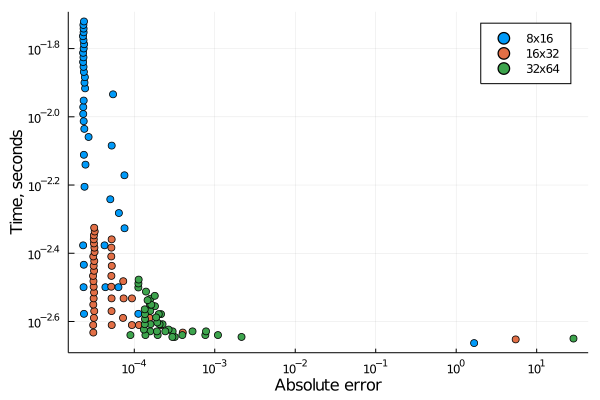

In [68]:
scatter(timeerr_8x16[1], timeerr_8x16[2],
        xaxis = :log10, yaxis = :log10,
        label = "8x16",
        xlabel = "Absolute error",
        ylabel = "Time, seconds")
scatter!(timeerr_16x32[1], timeerr_16x32[2],
        label = "16x32")
scatter!(timeerr_32x64[1], timeerr_32x64[2],
        label = "32x64")